# LangGraph ToolNode

Trong hướng dẫn này, chúng ta sẽ tìm hiểu cách sử dụng `ToolNode` được xây dựng sẵn của `LangGraph` cho việc gọi công cụ (tool invocation).
`ToolNode` là một `LangChain Runnable` nhận trạng thái đồ thị (graph state) chứa danh sách tin nhắn (messages) làm đầu vào và cập nhật trạng thái với kết quả của việc gọi công cụ.

Nó được thiết kế để hoạt động liền mạch với các agent được xây dựng sẵn của `LangGraph` và có thể hoạt động với bất kỳ `StateGraph` nào, miễn là trạng thái bao gồm một khóa messages với một reducer phù hợp.

Bây giờ, hãy khám phá cách tối đa hóa năng suất bằng cách sử dụng `LangGraph ToolNode`. 🚀


In [1]:
from typing import List, Dict, Optional
from urllib.parse import quote
import feedparser


class GoogleNews:

    def _fetch_news(self, url: str, k: int = 3) -> List[Dict[str, str]]:
        news_data = feedparser.parse(url)
        return [
            {"title": entry.title, "link": entry.link}
            for entry in news_data.entries[:k]
        ] # type: ignore

    def _collect_news(self, news_list: List[Dict[str, str]]) -> List[Dict[str, str]]:
        if not news_list:
            print("There is no news for the keyword.")
            return []

        result = []
        for news in news_list:
            result.append({"url": news["link"], "content": news["title"]})

        return result

    def search_by_keyword(
        self, keyword: Optional[str] = None, k: int = 3
    ) -> List[Dict[str, str]]:

        if keyword:
            encoded_keyword = quote(keyword)
            url = f"https://news.google.com/rss/search?q={encoded_keyword}&hl=vi&gl=VN&ceid=VN%3Avi"
        else:
            url = f"https://news.google.com/rss?hl=vi&gl=VN&ceid=VN%3Avi"

        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)

In [2]:
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from typing import List, Dict

@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

In [3]:
code = """
print("Hello world")
"""

python_code_interpreter(code)

/tmp/ipykernel_591464/1641296905.py:5: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  python_code_interpreter(code)


'Hello world\n'

Tiếp theo, chúng ta sẽ khám phá cách sử dụng `ToolNode` để gọi các công cụ (tools).

`ToolNode` được khởi tạo với một danh sách các công cụ và các đối số sau:

* `Args:`
    * `tools`: Một chuỗi các công cụ (tools) có thể được gọi bởi `ToolNode`.
    * `name`: Tên của `ToolNode` trong đồ thị (graph). Mặc định là "tools".
    * `tags`: Các thẻ (tags) tùy chọn để liên kết với nút (node). Mặc định là "None".
    * `handle_tool_errors`: Cách xử lý các lỗi công cụ (tool errors) được sinh ra bởi các công cụ bên trong nút (node). Mặc định là "True".


In [4]:
from langgraph.prebuilt import ToolNode, tools_condition

# Generate tool list
tools = [search_news, python_code_interpreter]

# Initialize ToolNode
tool_node = ToolNode(tools, handle_tool_errors=True)

## Calling ToolNode manually

`ToolNode` hoạt động trên trạng thái đồ thị (graph state) với danh sách các tin nhắn (messages).

`AIMessage` được sử dụng để biểu diễn một tin nhắn với vai trò trợ lý (assistant). Đây là phản hồi từ mô hình, có thể bao gồm văn bản (text) hoặc yêu cầu gọi các công cụ (tools). Nó cũng có thể bao gồm các loại phương tiện khác như hình ảnh, âm thanh hoặc video, mặc dù điều này hiện tại vẫn chưa phổ biến.
* `Args:`
    * `content`: Nội dung của tin nhắn. Thường là một chuỗi (string), nhưng cũng có thể là một danh sách các khối nội dung (content blocks).
    * `tool_calls`: Một danh sách các lệnh gọi công cụ (tool calls) được liên kết với tin nhắn.
        * `name`: Tên của công cụ (tool) cần gọi.
        * `args`: Các đối số (arguments) để truyền cho công cụ.
        * `id`: Một định danh duy nhất (unique identifier) tùy chọn cho tin nhắn, lý tưởng nhất là được cung cấp bởi nhà cung cấp/mô hình đã tạo ra tin nhắn.
        * `type`: Loại của tin nhắn.

Nó mong đợi tin nhắn cuối cùng trong danh sách là một `AIMessage` với tham số `tool_calls`.

Hãy xem cách gọi `ToolNode` thủ công.


In [5]:
from langchain_core.messages import AIMessage

# Creating an AI message object with single tool call
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "Tesla new model"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

# Invoke single tool call with created message
tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMipgFBVV95cUxPSnluSGhIajNXbG1sWHVRMVVFLUFZUEx4SERUbkJ4R1lQemVXWDVKYUJwRTRUVkhKNGdWNTRwNDYwYmp0V0JMQ2NHZ3FxdGttTWJuMzEzekd4aTNPWmpLaE56dzN2eFhVS3pqaGJHQUtGellYVlVDZVlPWjM0TnBSTWhwd1haZUpmb2tZaWs3TzQxVVhYTi1QZmJmVVJ4ZHA0SHEwNFN3?oc=5", "content": "Model Y giá rẻ là giải pháp cứu doanh số Tesla ở Trung Quốc - Znews"}, {"url": "https://news.google.com/rss/articles/CBMiowFBVV95cUxPSkJrYnA5cmZjYmR4MC1YYWg0WGtRNlpkcjhRZTBnWk0wVllxazhYdGRtOFBBOG5WQ1RUQm16b2NSZEZmQzlicmdxdXpZQ1R4OG5qU2E3akdfNnJURk5zYjhybG9HbXFZZ19vMUxOLWNLSnEyS1dnWUJvV0l1dzIyM3NGbURLVUlfYktPWGhURURJbjhYdEZ2MHBfbTQ1Qm1PcXhR?oc=5", "content": "Kia EV4 2026: Đối thủ đáng gờm của Tesla Model 3 - Tạp chí Công Thương"}, {"url": "https://news.google.com/rss/articles/CBMiqgFBVV95cUxOSl8yNHN6N2cxaWV1aU9qMjZPTnNPelpjN1dVcG1GRXdDWDR6VmxabVdrcWFacFpvZ2tkOXlLU2xmMDVtdGJXRkU0SWt1NUZEUDhPVHJUUzJsUHQzM1hpb0QzaDBUNS1ZR05oMDlnV1RRRl9NUXFuZjJQdkw3bTNJMXJaS09qLTY2R

Nói chung, không cần thiết phải tạo thủ công một `AIMessage`, vì nó được tự động tạo bởi tất cả các mô hình trò chuyện LangChain (LangChain chat models) hỗ trợ gọi công cụ (tool invocation).

Ngoài ra, bằng cách truyền nhiều lệnh gọi công cụ (tool invocations) vào tham số `tool_calls` của một `AIMessage`, bạn có thể thực hiện các lệnh gọi công cụ song song (parallel tool invocations) bằng cách sử dụng `ToolNode`.


In [6]:
# Creating an AI message object with multiple tool calls
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "Tesla new model"},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "python_code_interpreter",
            "args": {"code": "print(1+2+3+4)"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

# Invoke multiple tool calls with created message
tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMipgFBVV95cUxPSnluSGhIajNXbG1sWHVRMVVFLUFZUEx4SERUbkJ4R1lQemVXWDVKYUJwRTRUVkhKNGdWNTRwNDYwYmp0V0JMQ2NHZ3FxdGttTWJuMzEzekd4aTNPWmpLaE56dzN2eFhVS3pqaGJHQUtGellYVlVDZVlPWjM0TnBSTWhwd1haZUpmb2tZaWs3TzQxVVhYTi1QZmJmVVJ4ZHA0SHEwNFN3?oc=5", "content": "Model Y giá rẻ là giải pháp cứu doanh số Tesla ở Trung Quốc - Znews"}, {"url": "https://news.google.com/rss/articles/CBMiowFBVV95cUxPSkJrYnA5cmZjYmR4MC1YYWg0WGtRNlpkcjhRZTBnWk0wVllxazhYdGRtOFBBOG5WQ1RUQm16b2NSZEZmQzlicmdxdXpZQ1R4OG5qU2E3akdfNnJURk5zYjhybG9HbXFZZ19vMUxOLWNLSnEyS1dnWUJvV0l1dzIyM3NGbURLVUlfYktPWGhURURJbjhYdEZ2MHBfbTQ1Qm1PcXhR?oc=5", "content": "Kia EV4 2026: Đối thủ đáng gờm của Tesla Model 3 - Tạp chí Công Thương"}, {"url": "https://news.google.com/rss/articles/CBMiqgFBVV95cUxOSl8yNHN6N2cxaWV1aU9qMjZPTnNPelpjN1dVcG1GRXdDWDR6VmxabVdrcWFacFpvZ2tkOXlLU2xmMDVtdGJXRkU0SWt1NUZEUDhPVHJUUzJsUHQzM1hpb0QzaDBUNS1ZR05oMDlnV1RRRl9NUXFuZjJQdkw3bTNJMXJaS09qLTY2R

## Using with LLMs

Để sử dụng các mô hình chat với khả năng gọi công cụ (tool calling), trước tiên chúng ta cần đảm bảo rằng mô hình nhận thức được các công cụ có sẵn.
LangChain cung cấp nhiều mô hình chat từ các nhà cung cấp khác nhau như `OpenAI GPT`, `Anthropic Claude`, `Google Gemini` và nhiều hơn nữa.
Bạn có thể truy cập [LangChain ChatModels](https://python.langchain.com/docs/integrations/chat/) để biết thêm chi tiết.



In [7]:
from langchain_ollama import ChatOllama
model_with_tools = ChatOllama(model='qwen2.5:7b', temperature=0).bind_tools(tools)

In [8]:
model_with_tools.invoke(
    "Write Python code to print the first 5 prime numbers."
).tool_calls

[{'name': 'python_code_interpreter',
  'args': {'code': 'def is_prime(n):\n    if n <= 1:\n        return False\n    for i in range(2, int(n**0.5) + 1):\n        if n % i == 0:\n            return False\n    return True\n\ncount = 0\nprimes = []\ni = 2\nwhile count < 5:\n    if is_prime(i):\n        primes.append(i)\n        count += 1\n    i += 1\nprint(primes)'},
  'id': 'ef342f28-dc09-48d2-8a12-6558a5041ec5',
  'type': 'tool_call'}]

In [9]:
# Processing messages through ToolNode and generating tool-based responses from LLM model
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "Write Python code to print the first 5 prime numbers."
            )
        ]
    }
)

{'messages': [ToolMessage(content='[2, 3, 5, 7, 11]\n', name='python_code_interpreter', tool_call_id='de9def06-94be-4b23-add7-7020da334aea')]}

## Using with Agent

Tiếp theo, hãy cùng khám phá cách sử dụng `ToolNode` trong đồ thị của `LangGraph`.

Chúng ta sẽ thiết lập việc triển khai đồ thị của [`ReAct Agent`]([https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation](https://www.google.com/search?q=https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/%23react-implementation)). Agent này nhận một truy vấn làm đầu vào và liên tục gọi các công cụ cho đến khi thu thập đủ thông tin để giải quyết truy vấn.|


`ToolNode` và mô hình `Ollama` sẽ được sử dụng cùng với các công cụ mà chúng ta vừa định nghĩa.

Hãy xây dựng một đồ thị với các bước sau:
1. Sử dụng mô hình LLM để xử lý tin nhắn và tạo phản hồi, trả về phản hồi kèm theo các lệnh gọi công cụ (tool calls).
2. Khởi tạo đồ thị quy trình làm việc dựa trên trạng thái tin nhắn.
3. Định nghĩa hai node mà chúng ta sẽ luân phiên giữa agent và các công cụ.
4. Kết nối điểm bắt đầu của quy trình làm việc với node agent.
5. Thiết lập phân nhánh có điều kiện từ node agent, kết nối đến một node công cụ hoặc một điểm cuối (endpoint).
6. Thiết lập các cạnh vòng tròn giữa node công cụ và node agent.
7. Kết nối node agent đến điểm cuối.
8. Biên dịch đồ thị quy trình làm việc đã định nghĩa và tạo một ứng dụng có thể thực thi.


In [11]:
# Import types for LangGraph workflow state and message processing
from langgraph.graph import StateGraph, MessagesState, START, END


# 1. Use LLM model to process messages and generate responses, return responses with tool calls
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


# 2. Initialize workflow graph based on message state
workflow = StateGraph(MessagesState)

# 3. Define the two nodes we will cycle between agent and tools
# Add agent and tools nodes to the workflow graph
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 4. Connect the workflow starting point to the agent node
workflow.add_edge(START, "agent")

# 5.Set up conditional branching from the agent node, connecting to a tool node or an endpoint
workflow.add_conditional_edges("agent", tools_condition)

# 6. Set up circular edges between the tool node and the agent node
workflow.add_edge("tools", "agent")

# 7. Connect the agent node to the end point
workflow.add_edge("agent", END)

# 8. Compile the defined workflow graph and create an executable application
app = workflow.compile()

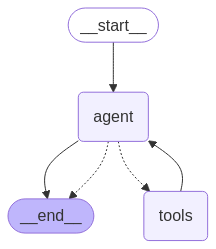

In [14]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [15]:
for chunk in app.stream(
    {"messages": [("human", "Write Python code to print the first 5 prime numbers.")]},
    stream_mode="values",
):
    # Print the last message
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Write Python code to print the first 5 prime numbers.
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (544ef41d-34ae-4601-9a0a-01921c18f03c)
 Call ID: 544ef41d-34ae-4601-9a0a-01921c18f03c
  Args:
    code: def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

count = 0
primes = []
i = 2
while count < 5:
    if is_prime(i):
        primes.append(i)
        count += 1
    i += 1
print(primes)
================================= Tool Message =================================
Name: python_code_interpreter

[2, 3, 5, 7, 11]

================================== Ai Message ==================================

The first 5 prime numbers are [2, 3, 5, 7, 11].


In [ ]:
# Search query
for chunk in app.stream(
    {"messages": [("human", "What is most played BTS song?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is most played BTS song?
================================== Ai Message ==================================
Tool Calls:
  search_news (39dfe233-ca54-41e6-8dac-1696c9872c4e)
 Call ID: 39dfe233-ca54-41e6-8dac-1696c9872c4e
  Args:
    query: BTS most played
================================= Tool Message =================================
Name: search_news

[{"url": "https://news.google.com/rss/articles/CBMisgFBVV95cUxOcjY4aTRPQjVTbml1SlY5ZUVrUFhpem8xVm1HU2I5V2hIbExWcXZrOTJCMHQwTGpnV0tqd2pSaHpTTFBYSUFYdXQ5eTJwdGR0YnU5QVlHZDItN2kzYjZzbEMzZFB2dTNWb010X3czczg0QmVmQ1FHbjhYdG03OF9RVTRNaXhxMTJhcWo0QnhTdGoxQW9BU2FSc2xkZk8tWlgzeWtuVzBkQkxPUENoNHpzSE9n?oc=5", "content": "Xem trực tiếp BTS ở lễ trao giải Asia Artist Awards 2024 tại đâu? - Báo Lao Động"}, {"url": "https://news.google.com/rss/articles/CBMiuAFBVV95cUxPWlZjcjk2cGdyZHF3RDM0cnJOYUZkZkxRZzctLVl3WjVqMjZ1YzE1d1B0NS1EZjc4SnBRVDFfeXQwbC1BUjVzb2tGZTRKZUxuS296dEl

In [ ]:
# Query that does not require tool call
for chunk in app.stream(
    {"messages": [("human", "Hi, How's it going?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

`ToolNode` can also handle errors that occur during tool execution.

You can enable/disable this feature by setting `handle_tool_errors=True` (enabled by default).